In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from datetime import datetime
from dateutil.parser import parse
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from scipy.stats import skew

In [2]:
df = pd.read_csv ("ODI_2025.csv", sep = ';')
df.columns = df.columns.str.strip()

In [3]:
numeric_cols = ['How many students do you estimate there are in the room?','What is your stress level (0-100)?',
    'How many hours per week do you do sports (in whole hours)?','Give a random number']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

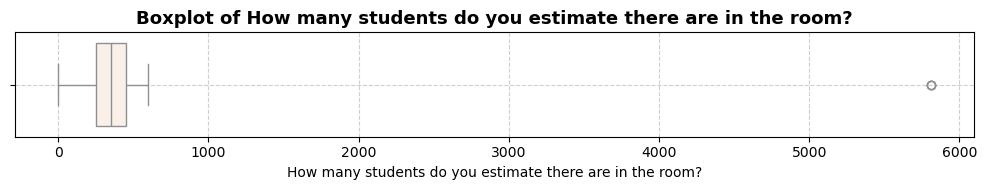

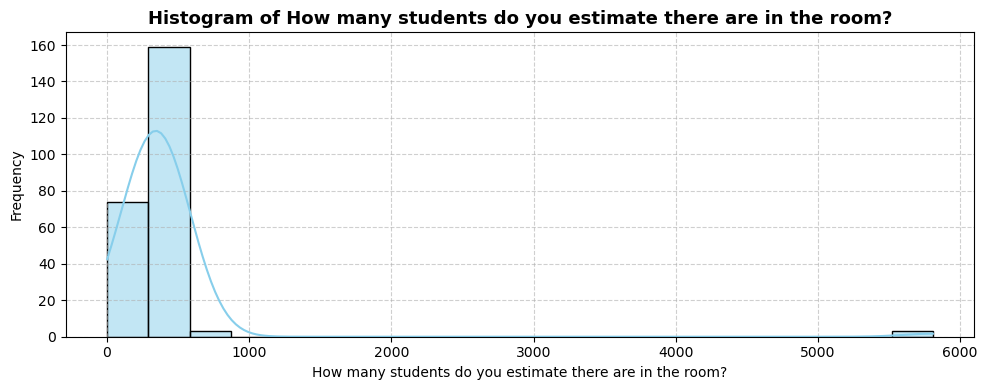

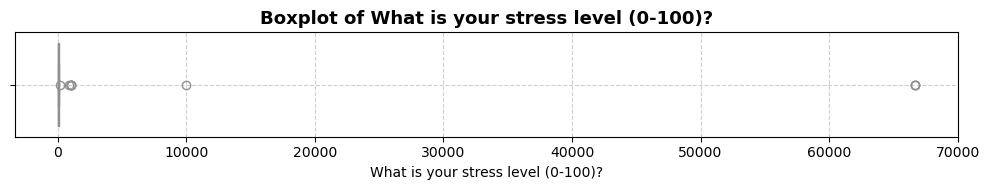

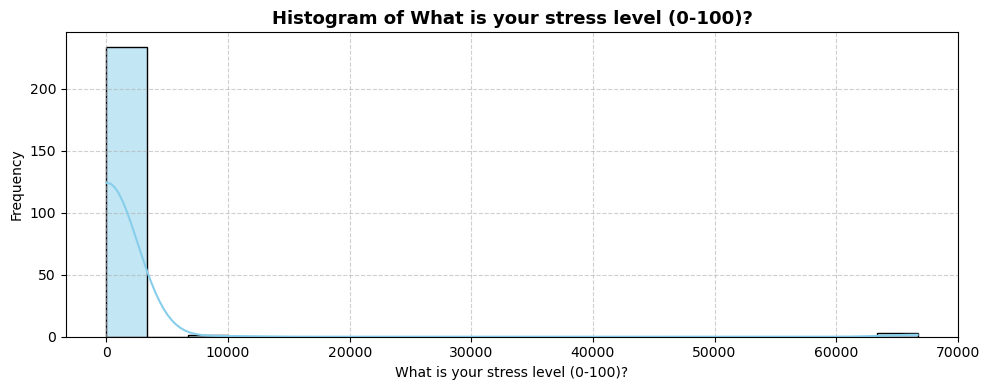

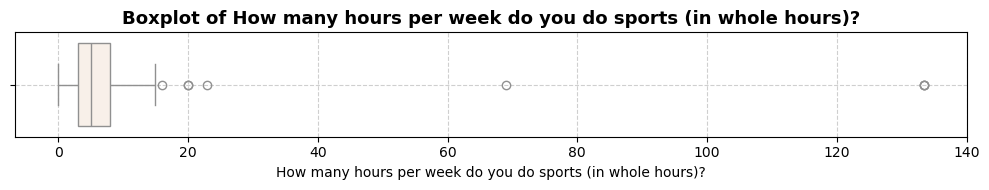

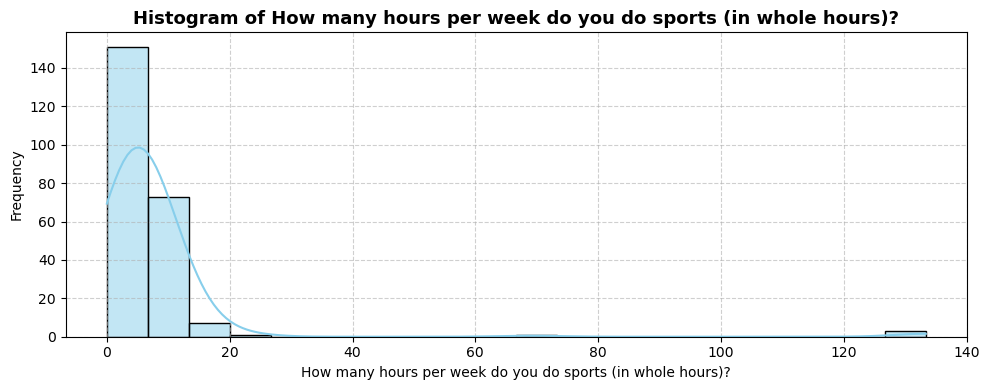

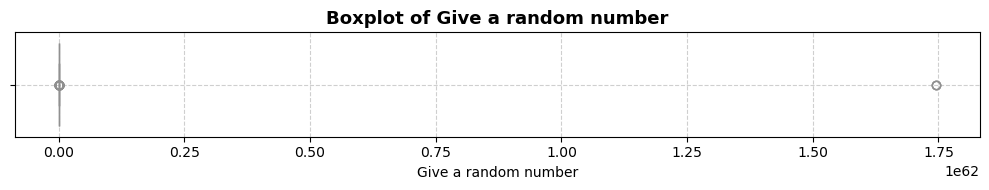

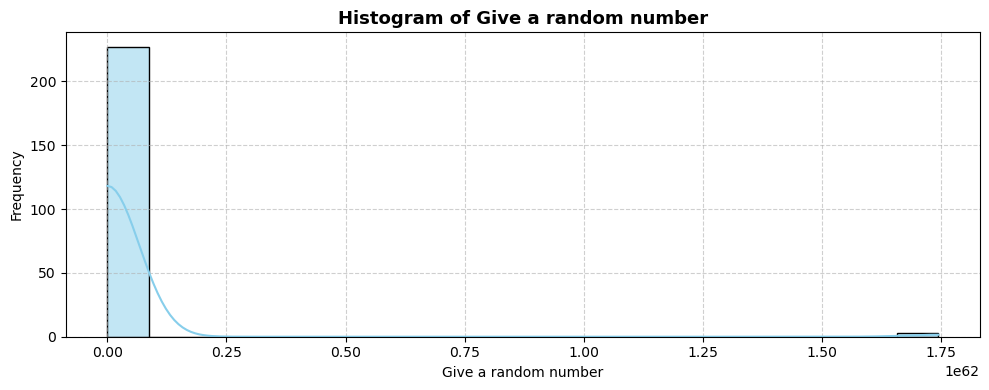

In [4]:
#Task 1A
for col in numeric_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    clipped_data = df[col].clip(lower, upper)
    
    plt.figure(figsize=(10, 2))
    sns.boxplot(x=clipped_data, color="linen")
    plt.title(f'Boxplot of {col}', fontsize=13, fontweight='bold')
    plt.xlabel(col)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Histogram with KDE
    plt.figure(figsize=(10, 4))
    sns.histplot(clipped_data, bins=20, kde=True, color="skyblue", edgecolor='black')
    plt.title(f'Histogram of {col}', fontsize=13, fontweight='bold')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

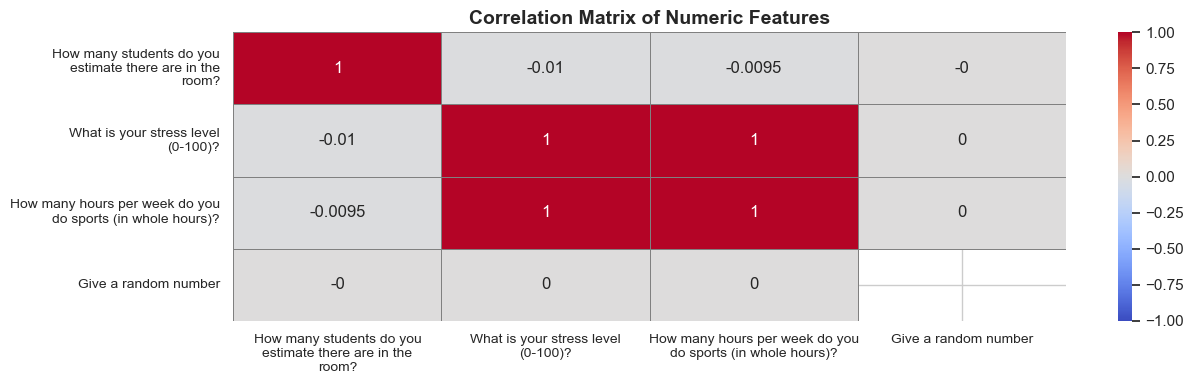

In [5]:
import textwrap
wrapped_labels = [textwrap.fill(label, width=30) for label in numeric_cols]

corr_matrix = df[numeric_cols].corr(method='pearson')

sns.set(style="whitegrid")
plt.figure(figsize=(13, 4))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',vmin=-1,vmax=1,xticklabels=wrapped_labels,yticklabels=wrapped_labels,linewidths=0.5,linecolor='gray')
plt.title('Correlation Matrix of Numeric Features', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, ha='center', fontsize=10)
plt.yticks(rotation=0, va='center', fontsize=10)
plt.tight_layout()
plt.show()

In [6]:
number_words = {
    'zero': 0.0,
    'one': 1.0,
    'two': 2.0,
    'three': 3.0,
    'four': 4.0,
    'five': 5.0,
    'six': 6.0,
    'seven': 7.0,
    'eight': 8.0,
    'nine': 9.0,
    'ten': 10.0,
}

def parse_numeric_value(val): ## Attempts to parse a messy string into a float. Returns None if parsing fails. ##
    if not isinstance(val, str):
        return val

    val = val.strip().lower()
    if not val:
        return None

    if val in number_words:
        return number_words[val]

    # Check for range like "180-200"
    range_match = re.match(r'^(\d+(?:\.\d+)?)\s*-\s*(\d+(?:\.\d+)?)$', val)
    if range_match:
        low = float(range_match.group(1))
        high = float(range_match.group(2))
        return (low + high) / 2.0

    # Check for arithmetic expression like "20*5*5"
    expr_match = re.match(r'^[0-9\.\+\-\*/\s]+$', val)
    if expr_match:
        try:
            return float(eval(val))
        except:
            pass

    # Replace commas if it's likely a decimal comma
    val_decimal = val.replace(',', '.')

    # Extract numeric substring from text
    num_search = re.search(r'[+-]?\d+(\.\d+)?([eE][+-]?\d+)?', val_decimal)
    if num_search:
        num_str = num_search.group(0)
        try:
            return float(num_str)
        except:
            return None

    return None

In [7]:
def clean_bedtime(val):
    if not isinstance(val, str):
        return np.nan

    val = val.strip().lower()
    if val in ['-', 'idk', 'unknown', '/', 'not today', 'n/a', 'null', 'late', '', ' ']:
        return np.nan
    if "midnight" in val:
        return "00:00"
    
    try:
        if re.match(r'^\d{1,2}h\d{1,2}(m)?$', val):
            val = re.sub(r'h', ':', val)
            val = re.sub(r'm', '', val)

        if re.match(r'^\d+\.\d+$', val):
            hr = int(float(val))
            mins = int(round((float(val) - hr) * 60))
            return f"{hr:02}:{mins:02}"

        if re.match(r'^\d{3,4}$', val):
            if len(val) == 3:
                return f"0{val[0]}:{val[1:]}"
            elif len(val) == 4:
                return f"{val[:2]}:{val[2:]}"

        if re.match(r'^\d{1,2}$', val):
            return f"{int(val):02}:00"

        if re.match(r'^\d{1,2}:\d{2}(:\d{2})?$', val):
            parts = val.split(":")
            return f"{int(parts[0]):02}:{int(parts[1]):02}"

        match = re.search(r'(\d{1,2})[:.]?(\d{0,2})\s*(am|pm)', val)
        if match:
            hour = int(match.group(1))
            minute = int(match.group(2)) if match.group(2) else 0
            suffix = match.group(3)

            if suffix == "pm" and hour != 12:
                hour += 12
            elif suffix == "am" and hour == 12:
                hour = 0

            return f"{hour:02}:{minute:02}"
    except:
        return np.nan

    return np.nan

df['Bedtime_Cleaned_24h'] = df['Time you went to bed Yesterday'].apply(clean_bedtime)

In [8]:
def log_transform(x):
    """
    Signed log transform:
    - 0 stays 0
    - Positive x -> log1p(x)
    - Negative x -> -log1p(|x|)
    """
    if pd.isnull(x):
        return np.nan
    if x == 0:
        return 0.0
    # sign(x) * ln(1 + |x|)
    return np.sign(x) * np.log1p(abs(x))

def clean_iqr(series, parse_fn, iqr_factor=1.5, extreme="no"):
    """
    1) Parses each element in series using parse_fn, converting to float.
    2) If extreme == "yes", applies a signed log transform on the parsed values.
    3) Computes Q1, Q3, and IQR (Q3 - Q1) on the resulting data.
    4) Flags outliers (< Q1 - iqr_factor*IQR or > Q3 + iqr_factor*IQR)
       and sets them to NaN.
    """

    #Parse raw values
    parsed = series.apply(parse_fn).astype(float)

    #If extreme == "yes", apply signed log transform
    if extreme.lower() == "yes":
        parsed = parsed.apply(log_transform)

    #Compute IQR on (optionally) transformed data
    q1 = parsed.quantile(0.25)
    q3 = parsed.quantile(0.75)
    iqr = q3 - q1

    if iqr == 0 or pd.isnull(iqr):
        #If there's no variation, just return as is
        return parsed

    lower_bound = q1 - iqr_factor * iqr
    upper_bound = q3 + iqr_factor * iqr

    #Mark out-of-bounds values as NaN
    parsed[(parsed < lower_bound) | (parsed > upper_bound)] = np.nan

    return parsed

In [9]:
def clean_with_clipping(series, lower = 0, upper = 100):
    """
    Parse into numeric and clip to [0, 100].
    """
    parsed = series.apply(parse_numeric_value).astype(float)
    return parsed.clip(lower = lower , upper=upper)

In [10]:
def clean_students_in_room(series):
    """
    Parse into numeric; treat negative as NaN.
    """
    parsed = series.apply(parse_numeric_value).astype(float)
    parsed.loc[parsed < 0] = np.nan
    return parsed

In [11]:
# Outlier Cleaning
df.iloc[:, 9] = clean_iqr(df.iloc[:, 9], parse_numeric_value, iqr_factor = 1.5, extreme = "no")
df.iloc[:, 9] = clean_students_in_room(df.iloc[:, 9])
df.iloc[:, 10] = clean_with_clipping(df.iloc[:, 10], lower = 0, upper = 100)
df.iloc[:, 11] = clean_with_clipping(df.iloc[:, 11], lower = 0, upper = 60)
df.iloc[:, 12] = clean_iqr(df.iloc[:, 12], parse_numeric_value, iqr_factor = 3.5, extreme = "yes")

In [12]:
## Framing the logic to decide if the value should be considered missing: ##1. Empty or known placeholders, ##2. No letters at all.
##3. More than 3 'invalid' characters (anything not a-z, A-Z, '!', or '?' -- ignoring whitespace)##
def is_missing(value):
    val = str(value).strip()

    placeholders = ["-", "n/a", "none", "()", "nan"]
    if val == "" or val.lower() in placeholders:
        return True

    if not re.search(r"[a-zA-Z]", val):
        return True

    invalid_chars = re.findall(r"[^a-zA-Z!\?\.\:\(\)\-\s]", val)
    if len(invalid_chars) > 3:
        return True

    return False

df.iloc[:, 1] = df.iloc[:, 1].apply(lambda x: np.nan if is_missing(x) else x)
df.iloc[:, 14] = df.iloc[:, 14].apply(lambda x: np.nan if is_missing(x) else x)
df.iloc[:, 15] = df.iloc[:, 15].apply(lambda x: np.nan if is_missing(x) else x)

In [13]:
## generating cleaned output data file
import os
output_filename = "ODI_2025_Cleaned_Ver1.csv"
output_path = os.path.join(os.getcwd(), output_filename)

df.to_csv(output_path, index=False)
print(f"File saved successfully at: {output_path}")

File saved successfully at: C:\Users\lddin\OneDrive\Desktop\VU\DMT\Assignment 1\ODI_2025_Cleaned_Ver1.csv


In [14]:
#Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [15]:
def knn_numerical(dataframe, numeric_cols, n_neighbors=5): ## Scales numeric columns with StandardScaler, applies KNN imputation, and inverse-scales ##
    df_numeric = dataframe[numeric_cols]

    ## Temporary fill for scaling ##
    df_temp = df_numeric.fillna(df_numeric.mean())
    scaler = StandardScaler()
    df_numeric_scaled = scaler.fit_transform(df_temp)

    ## KNN Imputation ##
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_scaled = imputer.fit_transform(df_numeric_scaled)

    ## Inverse transform ##
    imputed = scaler.inverse_transform(imputed_scaled)

    ## Overwrite the original numeric columns ##
    dataframe.loc[:, numeric_cols] = imputed
    return dataframe

In [16]:
def random_categorical(df, categorical_cols, random_state=42): ## Impute missing categorical values by sampling from the existing distribution ##
    np.random.seed(random_state)
    for col in categorical_cols:
        missing_mask = df[col].isna()
        if not missing_mask.any():
            continue

        known_values = df.loc[~missing_mask, col]
        if known_values.empty:
            continue

        value_counts = known_values.value_counts(dropna=False)
        categories = value_counts.index
        freqs = value_counts.values.astype(float)
        probs = freqs / freqs.sum()

        n_missing = missing_mask.sum()
        random_fills = np.random.choice(categories, size=n_missing, p=probs)
        df.loc[missing_mask, col] = random_fills
    return df

In [17]:
def clean_missing_values(df, numeric_cols, categorical_cols, numeric_method='mean_median', cat_method='unknown',
    n_neighbors=5, random_state=42, skew_threshold=1.0):
### Handle missing values in numeric and categorical columns in place, returning the updated DataFrame reference. ###

### numeric_method: ###
    ### - 'mean_median': decides mean vs median based on skew ###
    ### - 'knn': uses KNN-based imputation ###

### cat_method: ###
    ### - 'unknown': fills missing categoricals with 'unknown' ###
    ### - 'random': samples from existing distribution in that column ###

### skew_threshold: ###
    ### - If abs(skew) > skew_threshold, use median; else use mean. ###

    imputation_log = {}

    ## 1. Handle Numeric Columns ##
    if numeric_method == 'mean_median':
        for col in numeric_cols:
            col_skew = df[col].skew(skipna=True)
            if abs(col_skew) > skew_threshold:
                impute_value = df[col].median(skipna=True)
                imputation_log[col] = "median"
            else:
                impute_value = df[col].mean(skipna=True)
                imputation_log[col] = "mean"
    
            df[col] = df[col].fillna(round(impute_value, 2))

    elif numeric_method == 'knn':
        ## If using KNN, it applies to all numeric columns ##
        df = knn_numerical(df, numeric_cols, n_neighbors=n_neighbors)
        for col in numeric_cols:
            imputation_log[col] = "knn"
    else:
        raise ValueError("numeric_method must be 'mean_median' or 'knn'")

    ## 2. Handle Categorical Columns ##
    if cat_method == 'unknown':
        for col in categorical_cols:
            df[col].fillna('unknown', inplace=True)
    elif cat_method == 'random':
        df = random_categorical(df, categorical_cols, random_state=random_state)
    else:
        raise ValueError("cat_method must be 'unknown' or 'random'")
    return df, imputation_log
    
df_cleaned, log = clean_missing_values(df, numeric_cols=numeric_cols, categorical_cols=categorical_cols, numeric_method='mean_median', 
                                       cat_method='random',skew_threshold=1.0, n_neighbors=5, random_state=42)

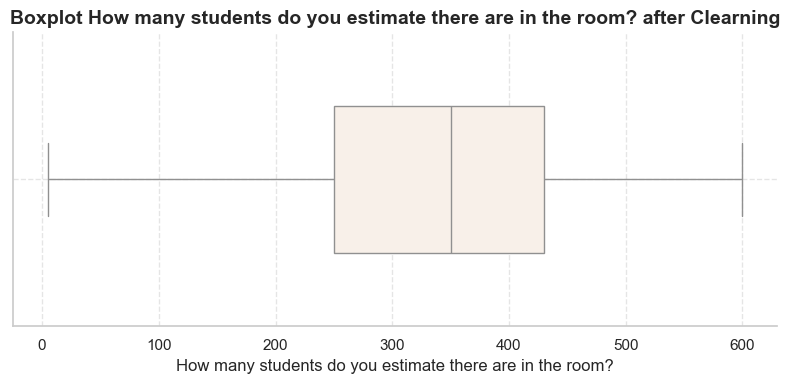

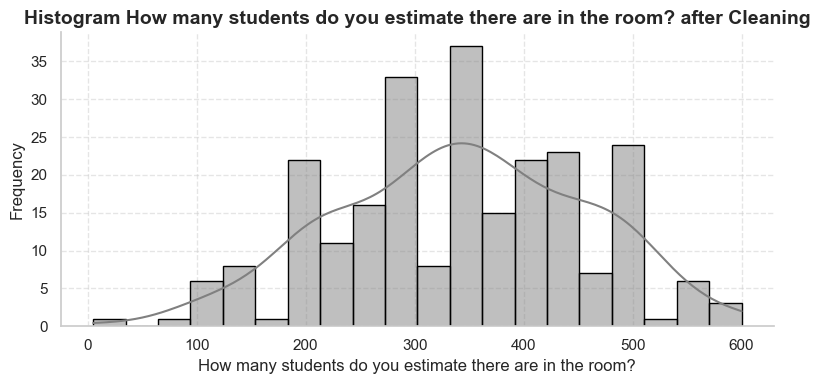

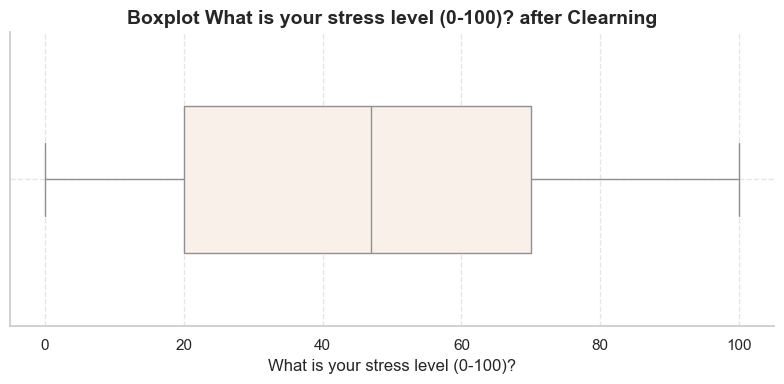

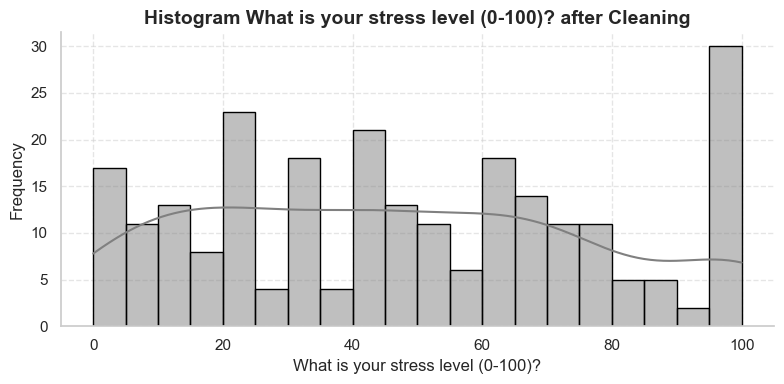

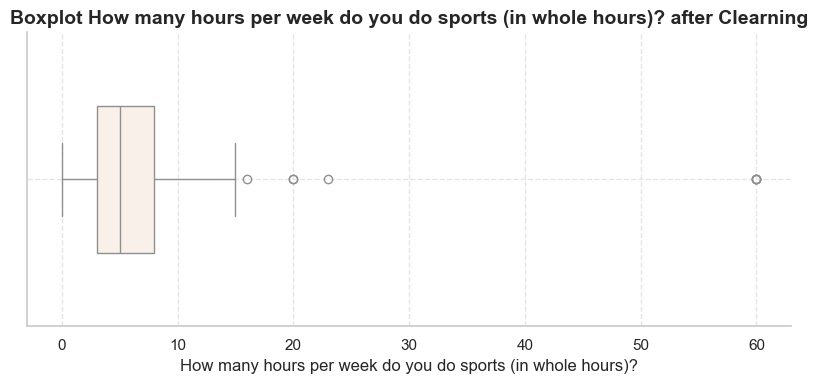

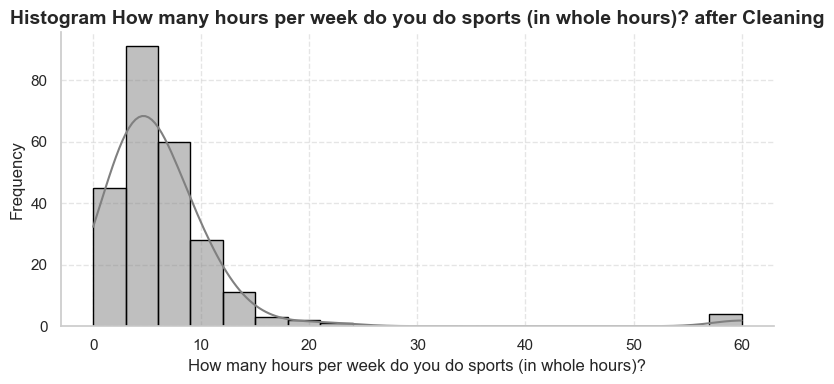

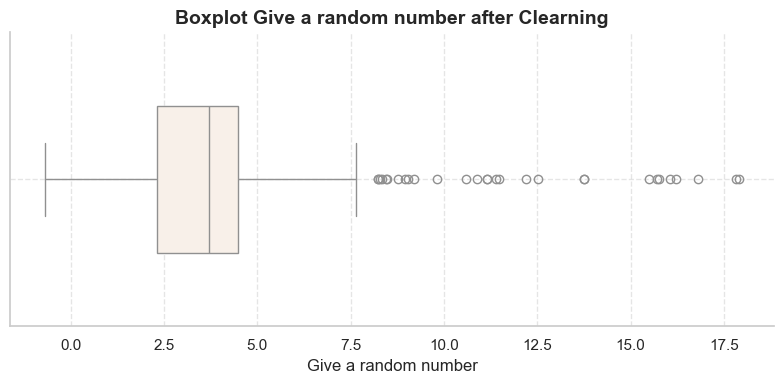

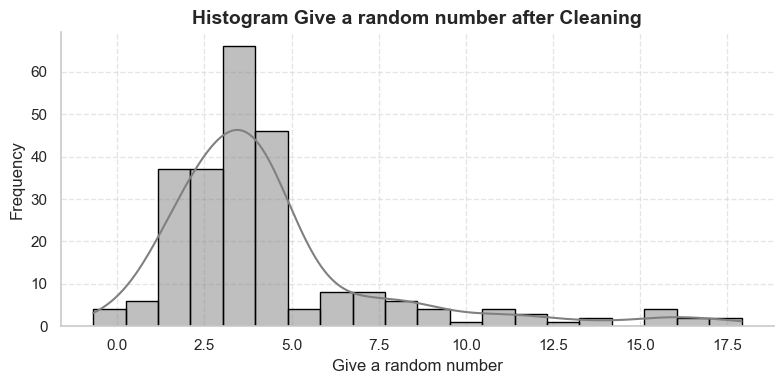

In [18]:
## Printing results ##
sns.set(style="whitegrid")
for col in numeric_cols:
    
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col], color="linen", width=0.5)
    plt.title(f'Boxplot {col} after Clearning', fontsize=14, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    sns.despine()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), bins=20, kde=True, color="grey", edgecolor='black')
    plt.title(f'Histogram {col} after Cleaning', fontsize=14, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    sns.despine()
    plt.tight_layout()
    plt.show()

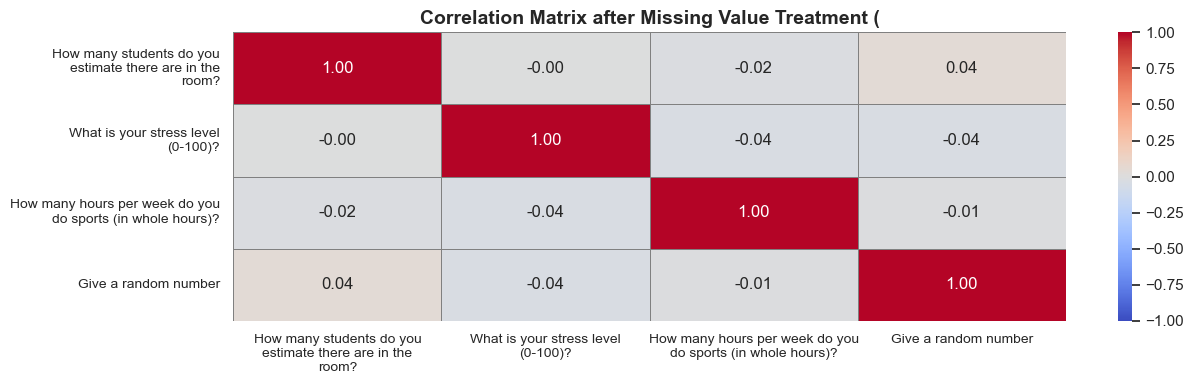

In [19]:
wrapped_labels = [textwrap.fill(label, width=30) for label in numeric_cols]

corr_matrix = df[numeric_cols].corr(method='pearson')

plt.figure(figsize=(13, 4))
sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap='coolwarm',vmin=-1,vmax=1,xticklabels=wrapped_labels,yticklabels=wrapped_labels,linewidths=0.5,
    linecolor='gray')
plt.title('Correlation Matrix after Missing Value Treatment (', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, ha='center', fontsize=10)
plt.yticks(rotation=0, va='center', fontsize=10)
plt.tight_layout()
plt.show()

In [20]:
## generating cleaned output data file
import os
output_filename = "ODI_2025_Cleaned_Ver2.csv"
output_path = os.path.join(os.getcwd(), output_filename)

df.to_csv(output_path, index=False)
print(f"File saved successfully at: {output_path}")

File saved successfully at: C:\Users\lddin\OneDrive\Desktop\VU\DMT\Assignment 1\ODI_2025_Cleaned_Ver2.csv


In [21]:
## Feature Engineering ##

## Applying log(1 + x) transformation to handle skewness in numeric data] ##
def log_transform(series): 
    return np.log1p(series)

## Standardizes the series using Z-score normalization ##
def zscore_normalize(series): 
    mean = series.mean()
    std = series.std()
    return (series - mean) / std

## Bins stress level into 0 or 1: 0 = low/moderate stress, 1 = high stress ##
def binary_stress_level(series, threshold=60): 
    return (series > threshold).astype(int)

## Creates a ratio of stress to physical activity ##
def stress_to_sports_ratio(stress_series, sports_series): 
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = stress_series / (sports_series + 1e-5)
        ratio.replace([np.inf, -np.inf], np.nan, inplace=True)
        return ratio

## Discretizes sports hours into buckets: 0 = none, 1 = low (1–3 hrs), 2 = medium (4–8), 3 = high (>8) ##
def categorize_sports_hours(series): 
    return pd.cut(series, bins=[-1, 0, 3, 8, 100], labels=[0, 1, 2, 3]).astype(int)

## Creating a new feature as the interaction of stress level and random number ##
def interaction_feature(stress_series, random_series): 
    return stress_series * random_series

## Flagging: Based on 'Time you went to bed Yesterday'(text).Returns 1 if bedtime > 12:00 AM, else 0 ##
def is_night_owl(series): 
    def extract_hour(val):
        try:
            if pd.isna(val) or val == 'unknown':
                return np.nan
            return int(str(val).split(":")[0])
        except:
            return np.nan

    hours = series.apply(extract_hour)
    return (hours >= 0) & (hours <= 5)

## Now need to applyback the night owl flag ##
df['Is_Night_Owl'] = is_night_owl(df['Bedtime_Cleaned_24h'])

In [22]:
## Applying transformations for the data columns ##
df['Log_Students_Estimate'] = log_transform(df['How many students do you estimate there are in the room?'])
df['Stress_High_Flag'] = binary_stress_level(df['What is your stress level (0-100)?'])
df['Stress_Random_Interaction'] = interaction_feature(df['What is your stress level (0-100)?'],df['Give a random number'])
df['Zscore_Stress'] = zscore_normalize(df['What is your stress level (0-100)?'])
df['Sports_Hours_Bin'] = categorize_sports_hours(df['How many hours per week do you do sports (in whole hours)?'])
df['Stress_to_Sports_Ratio'] = stress_to_sports_ratio(df['What is your stress level (0-100)?'],
                                                      df['How many hours per week do you do sports (in whole hours)?'])
df['Is_Night_Owl'] = is_night_owl(df['Bedtime_Cleaned_24h'])

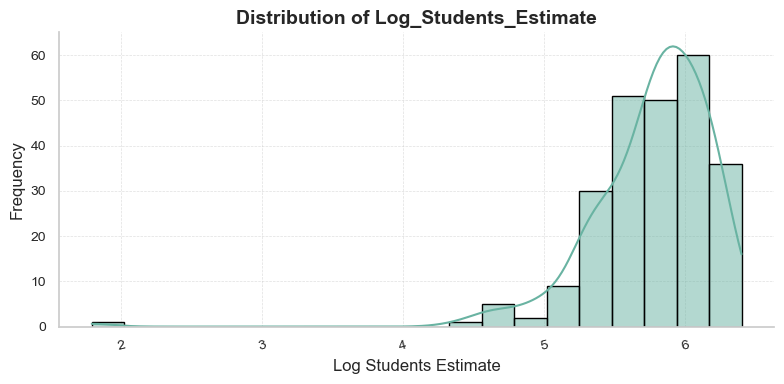

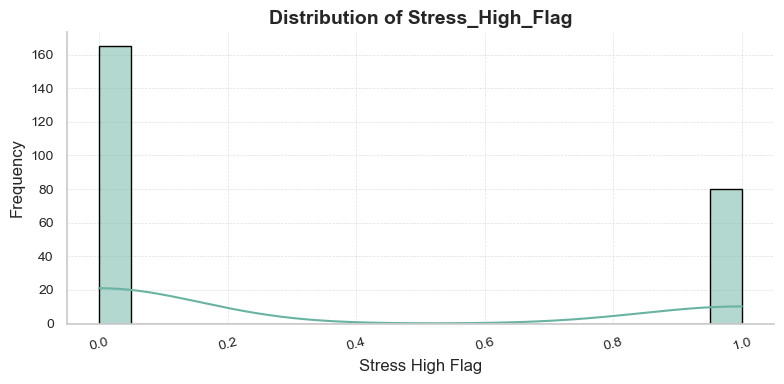

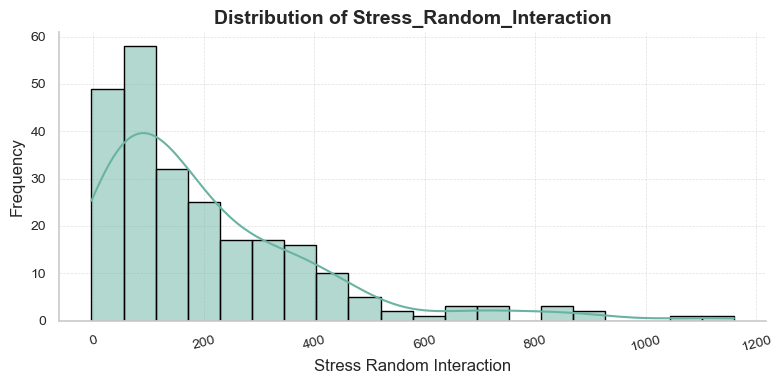

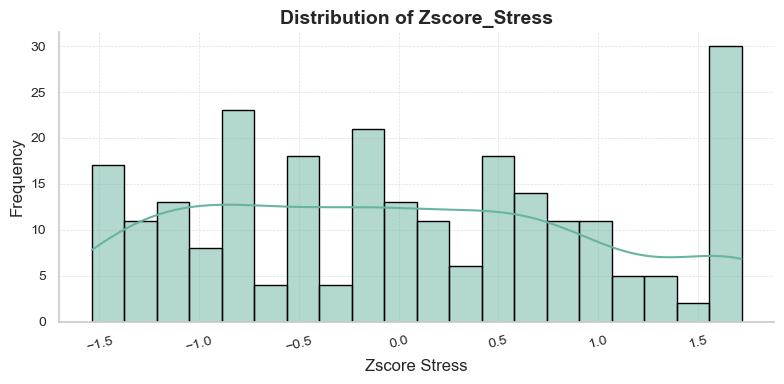

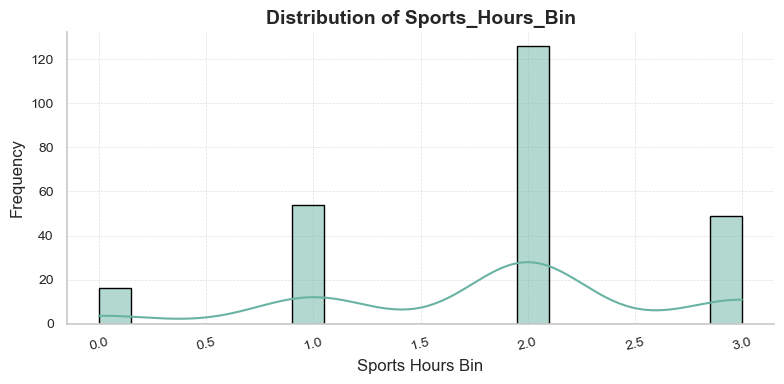

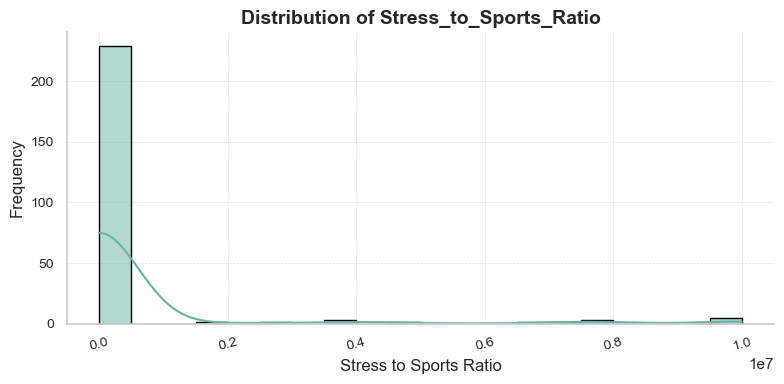

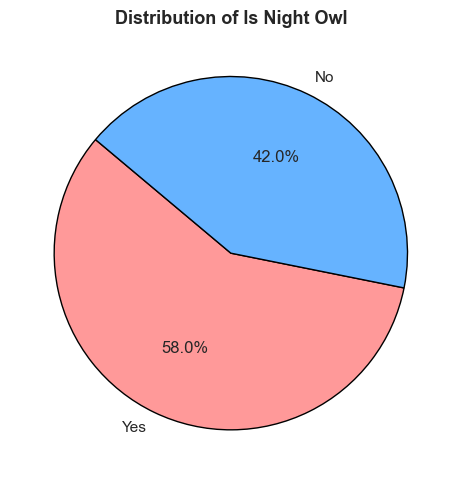

In [23]:
## Distributions after applying transformations ##
new_features = ['Log_Students_Estimate', 'Stress_High_Flag', 'Stress_Random_Interaction', 'Zscore_Stress','Sports_Hours_Bin',
                'Stress_to_Sports_Ratio']

for col in new_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, bins=20, kde=True, color="#69b3a2", edgecolor='black')

    plt.title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    plt.xlabel(col.replace('_', ' '), fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

    plt.xticks(fontsize=10, rotation=15)
    plt.yticks(fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    
    sns.despine()
    plt.tight_layout()
    plt.show()

def plot_binary_pie(column):
    plt.figure(figsize=(5, 5))
    counts = df[column].value_counts(dropna=True)
    labels = ['Yes' if val == 1 else 'No' for val in counts.index]
    colors = ['#ff9999','#66b3ff']
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, wedgeprops={'edgecolor': 'black'})
    plt.title(f'Distribution of {column.replace("_", " ")}', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_binary_pie('Is_Night_Owl')

In [24]:
output_filename = "ODI_2025_Cleaned_Ver3.csv"
output_path = os.path.join(os.getcwd(), output_filename)

df.to_csv(output_path, index=False)
print(f"File saved successfully at: {output_path}")

File saved successfully at: C:\Users\lddin\OneDrive\Desktop\VU\DMT\Assignment 1\ODI_2025_Cleaned_Ver3.csv
